In [1]:
!pip install  safetensors
#!pip install --upgrade PyTorch 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.1 MB/s eta 0:00:00


In [2]:
import transformers
from safetensors import safe_open

print("Transformers Version:", transformers.__version__)


Transformers Version: 4.28.1


In [3]:
import warnings
from transformers import logging

warnings.filterwarnings('ignore')
logging.set_verbosity_error()


In [4]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [5]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.disable_caching()

data_dir = '../input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})

    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})

    return train_df, dev_df, test_df, dataset_dict

train_df, dev_df, test_df, vispam_datasets = load_data(data_dir)

In [6]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):

    def __init__(self, model_name, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()

        assert model_name in ['PhoBERT', 'visoBert', 'visoBert-14gb']

        self.model_name = model_name

        self.num_classes = 2

        if model_name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        elif model_name == 'visoBert':
            self.bert = AutoModel.from_pretrained('uitnlp/visobert')
        else:
            self.bert = AutoModel.from_pretrained('5CD-AI/visobert-14gb-corpus')

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        x = self.drop(output)
        x = self.fc(x)
        return x


In [7]:
AutoModel.from_pretrained('5CD-AI/visobert-14gb-corpus')

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(15004, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [8]:
import torch
import numpy as np

class EarlyStopping:

    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1

            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')

        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
import os
import gc
import json
import torch
from torch import nn
import numpy as np
from scipy import interpolate
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader):
    model.train()
    losses = []
    correct = 0

    trues = []
    predicts = []

    label_column = 'label'

    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]

        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader):
    model.eval()
    losses = []
    correct = 0

    trues = []
    predicts = []

    label_column = 'label'

    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data[label_column].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pred = torch.max(outputs, dim=1)[1]

            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())

            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping):
    torch.cuda.empty_cache()
    gc.collect()

    Path(model.model_name).mkdir(parents=True, exist_ok=True)

    if early_stopping:
        path_checkpoint = os.path.join(model.model_name, f"{model.model_name}_checkpoint.pth")
        early_stopping.path = path_checkpoint

    best_f1 = 0
    best_model_path = os.path.join(model.model_name, f"{model.model_name}_best_model.pth")
    last_model_path = os.path.join(model.model_name, f"{model.model_name}_last_model.pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*50)

        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader)

        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)

        print("Train Accuracy: {:.4f} - Train F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))

        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1

        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            break

        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break

    history_path = os.path.join(model.model_name, f"{model.model_name}_history.json")
    with open(history_path, 'w') as f:
        json.dump(history, f)

    # with open(history_path) as f:
    #     history = json.load(f)

    return history


def test(model, dataloader):
    model.eval()
    predicts =[]
    predict_probs = []
    true_labels = []

    label_column = 'label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())

    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))

    return test_cm

def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)

    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()


def plotting_confusion_matrix(confusion_matrix):
    labels = ['no-spam', 'spam']
    font_size = 30
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()


In [10]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = vispam_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = vispam_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels)
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [11]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

# PhoBERT

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_data(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


In [14]:
from torch import nn
from transformers import get_linear_schedule_with_warmup

seed_everything(42)
model = ViSpam_Classifier(model_name="PhoBERT").to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 10
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping)

Epoch 1/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8337 - Train F1-score: 0.7949 - Train Loss: 0.4083
Valid Accuracy: 0.8829 - Valid F1-score: 0.8233 - Valid Loss: 0.5373
Validation loss decreased (inf --> 0.537346). Saving model ...
Epoch 2/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8930 - Train F1-score: 0.8650 - Train Loss: 0.3068
Valid Accuracy: 0.8855 - Valid F1-score: 0.8518 - Valid Loss: 0.3525
Validation loss decreased (0.537346 --> 0.352486). Saving model ...
Epoch 3/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9221 - Train F1-score: 0.9009 - Train Loss: 0.2492
Valid Accuracy: 0.8962 - Valid F1-score: 0.8590 - Valid Loss: 0.4467
EarlyStopping counter: 1 out of 3
Epoch 4/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9418 - Train F1-score: 0.9255 - Train Loss: 0.2157
Valid Accuracy: 0.8892 - Valid F1-score: 0.8378 - Valid Loss: 0.7335
EarlyStopping counter: 2 out of 3
Epoch 5/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9569 - Train F1-score: 0.9447 - Train Loss: 0.1722
Valid Accuracy: 0.8980 - Valid F1-score: 0.8579 - Valid Loss: 0.6699
EarlyStopping counter: 3 out of 3
Early stopping.


In [15]:
plotting_history(history)

In [16]:
import os
import torch

model_name = "PhoBERT"
model_path = os.path.join(model_name, f"{model_name}_last_model.pth")
model = ViSpam_Classifier(model_name).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8928
Precision: 0.8810
Recall: 0.8350
F1-score: 0.8541
Confusion matrix:
 [[2789  122]
 [ 303  749]]
              precision    recall  f1-score   support

           0     0.9020    0.9581    0.9292      2911
           1     0.8599    0.7120    0.7790      1052

    accuracy                         0.8928      3963
   macro avg     0.8810    0.8350    0.8541      3963
weighted avg     0.8908    0.8928    0.8893      3963



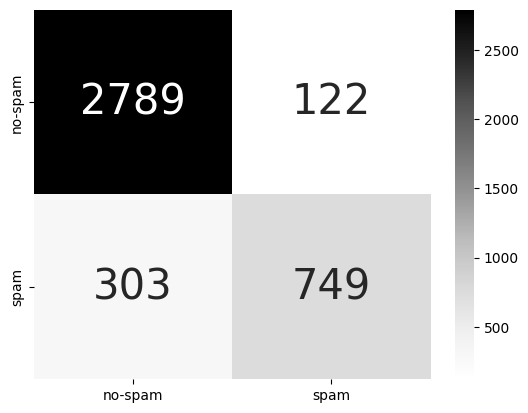

In [17]:
plotting_confusion_matrix(test_cm)


# visobert

In [18]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("uitnlp/visobert")

def encode_data(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


In [20]:
from transformers import get_linear_schedule_with_warmup
seed_everything(42)
model = ViSpam_Classifier(model_name="visoBert").to(device)
optimizer =torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 10
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)


In [21]:
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping)

Epoch 1/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8658 - Train F1-score: 0.8339 - Train Loss: 0.3511
Valid Accuracy: 0.9043 - Valid F1-score: 0.8749 - Valid Loss: 0.3211
Validation loss decreased (inf --> 0.321107). Saving model ...
Epoch 2/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9355 - Train F1-score: 0.9179 - Train Loss: 0.2144
Valid Accuracy: 0.9025 - Valid F1-score: 0.8711 - Valid Loss: 0.3717
EarlyStopping counter: 1 out of 3
Epoch 3/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9717 - Train F1-score: 0.9637 - Train Loss: 0.1178
Valid Accuracy: 0.9006 - Valid F1-score: 0.8714 - Valid Loss: 0.5373
EarlyStopping counter: 2 out of 3
Epoch 4/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9851 - Train F1-score: 0.9809 - Train Loss: 0.0621
Valid Accuracy: 0.9006 - Valid F1-score: 0.8639 - Valid Loss: 0.8918
EarlyStopping counter: 3 out of 3
Early stopping.


In [22]:
import os
import torch

model_name = "visoBert"
model_path = os.path.join(model_name, f"{model_name}_last_model.pth")
model = ViSpam_Classifier(model_name).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.9039
Precision: 0.8844
Recall: 0.8641
F1-score: 0.8735
Confusion matrix:
 [[2762  149]
 [ 232  820]]
              precision    recall  f1-score   support

           0     0.9225    0.9488    0.9355      2911
           1     0.8462    0.7795    0.8115      1052

    accuracy                         0.9039      3963
   macro avg     0.8844    0.8641    0.8735      3963
weighted avg     0.9023    0.9039    0.9026      3963



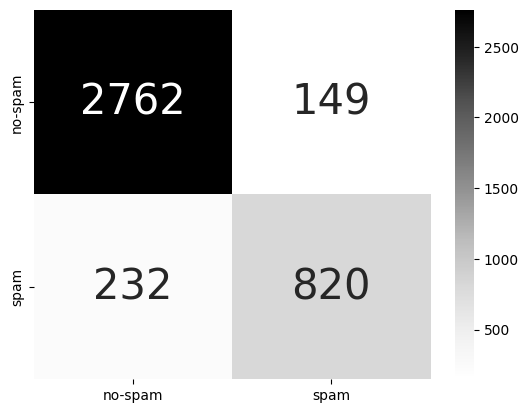

In [23]:
plotting_confusion_matrix(test_cm)


# 5CDAI-visobert 14k

In [24]:
from transformers import BertTokenizer

tokenizer = AutoTokenizer.from_pretrained("5CD-AI/visobert-14gb-corpus")

def encode_data(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [25]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)


In [26]:
from torch import nn

seed_everything(42)
model = ViSpam_Classifier(model_name="visoBert-14gb").to(device)
optimizer =torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5) # 5e-5, 2e-5, 3e-5
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
epochs = 10
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*epochs)
early_stopping = EarlyStopping(patience=3, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, early_stopping)


Epoch 1/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.8523 - Train F1-score: 0.8164 - Train Loss: 0.3785
Valid Accuracy: 0.8936 - Valid F1-score: 0.8590 - Valid Loss: 0.3709
Validation loss decreased (inf --> 0.370873). Saving model ...
Epoch 2/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9163 - Train F1-score: 0.8939 - Train Loss: 0.2576
Valid Accuracy: 0.8987 - Valid F1-score: 0.8629 - Valid Loss: 0.3913
EarlyStopping counter: 1 out of 3
Epoch 3/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9530 - Train F1-score: 0.9398 - Train Loss: 0.1844
Valid Accuracy: 0.8836 - Valid F1-score: 0.8543 - Valid Loss: 0.5448
EarlyStopping counter: 2 out of 3
Epoch 4/10
--------------------------------------------------


  0%|          | 0/893 [00:00<?, ?it/s]

Train Accuracy: 0.9701 - Train F1-score: 0.9616 - Train Loss: 0.1260
Valid Accuracy: 0.8949 - Valid F1-score: 0.8629 - Valid Loss: 0.6264
EarlyStopping counter: 3 out of 3
Early stopping.


In [27]:
plotting_history(history)


In [28]:
import os
import torch

model_name = "visoBert-14gb"
model_path = os.path.join(model_name, f"{model_name}_last_model.pth")
model = ViSpam_Classifier(model_name).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader)
test_cm = evaluate(true_labels, predicts)


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8870
Precision: 0.8537
Recall: 0.8584
F1-score: 0.8560
Confusion matrix:
 [[2676  235]
 [ 213  839]]
              precision    recall  f1-score   support

           0     0.9263    0.9193    0.9228      2911
           1     0.7812    0.7975    0.7893      1052

    accuracy                         0.8870      3963
   macro avg     0.8537    0.8584    0.8560      3963
weighted avg     0.8878    0.8870    0.8873      3963



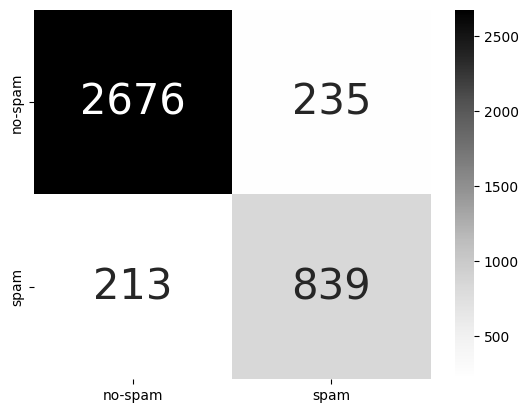

In [29]:
plotting_confusion_matrix(test_cm)
